In [21]:
import pandas as pd
import numpy as np
import PIL
from keras.applications import VGG16,imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.models import Model
from keras.layers import Dense
import numpy as np
import glob
import os

import pickle
import time


In [3]:
df = pd.read_table('Data/DeepFashion/list_attr_img.txt',skiprows=1,sep='\s+',header=None)

In [4]:
bbox = pd.read_table('Data/DeepFashion/list_bbox.txt',sep='\s+')

In [5]:
joined = bbox.join(df,lsuffix='image_name',rsuffix='0')

In [6]:
joined.shape[0]

289222

In [7]:
inputShape = (224, 224)
preprocess = imagenet_utils.preprocess_input

def preprocess_DF(bbox):
    image = crop_resize_DF(bbox)
    image = img_to_array(image)
    image = np.expand_dims(image,axis=0)
    
    return preprocess(image)

def crop_resize_DF(bbox):
    img = PIL.Image.open('./Data/DeepFashion/'+bbox['image_name'])
    lx = bbox['x_1']
    ly = bbox['y_1']
    ux = bbox['x_2']
    uy = bbox['y_2']
    
    img = img.crop((lx,ly,ux,uy))
    img = img.resize(inputShape, PIL.Image.ANTIALIAS)
    return img

In [94]:
def generator(df, batch_size):
    while True:
        subset = np.random.randint(df.shape[0],size=batch_size)
        proc_imgs = []
        for i in range(batch_size):
            proc_imgs.append(np.squeeze(preprocess_DF(df.iloc[i])))
    
        attr = (df.iloc[subset,6:].values>0)
        yield np.array(proc_imgs), attr

In [9]:
joined.head()

,image_name,x_1,y_1,x_2,y_2,0,1,2,3,4,...,991,992,993,994,995,996,997,998,999,1000
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,72,79,232,273,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,67,59,155,161,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,65,65,156,200,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,51,62,167,182,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,46,88,166,262,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [10]:
attr = (joined.iloc[:,6:].values>0)

In [149]:
pos_weight = np.prod(attr.shape)/np.sum(attr)

In [150]:
pos_weight

300.95628557455177

In [11]:
class_weights = 1/(np.mean(attr,axis=0)*1000+1e-8)

In [156]:
import keras.backend as K
import tensorflow as tf

def weighted_sigmoid_loss(y_true,y_pred):
    return tf.nn.weighted_cross_entropy_with_logits(y_true,y_pred,pos_weight=pos_weight)

def H_pred(y_true, y_pred):
    return K.mean(K.sum(K.abs(y_true-y_pred),axis=1))

base_model = VGG16(weights='imagenet')
x = base_model.get_layer('fc2').output
predictions = Dense(1000, activation='sigmoid',name='predictions')(x)

new_model = Model(inputs=base_model.input, outputs=predictions)

for layer in new_model.layers[:19]:
    layer.trainable = False


new_model.compile(optimizer='adam', loss=weighted_sigmoid_loss, metrics=[H_pred])

In [157]:
from keras import callbacks
import time
tbCB = callbacks.TensorBoard(log_dir="logs/{}".format(time.time()), histogram_freq=0, write_graph=False, write_images=False)
checkpointCB = callbacks.ModelCheckpoint("checkpoints/{}".format(time.time()))

h = new_model.fit_generator(generator(joined,64),steps_per_epoch=4,epochs=1,verbose=1,
                            callbacks=[tbCB,checkpointCB],class_weight=class_weights)

Epoch 1/1
4/4 [==============================] - 157s - loss: 1.2940 - H_pred: 228.4331    


In [159]:
p = new_model.predict(proc_tops[:20])

In [161]:
np.where(p[0,:]>0.5)

(array([  1,  50,  81,  93, 108, 112, 118, 141, 142, 162, 196, 204, 212,
        227, 236, 239, 254, 282, 285, 287, 309, 310, 327, 335, 337, 353,
        358, 365, 368, 380, 413, 429, 441, 453, 457, 482, 495, 513, 543,
        546, 547, 560, 577, 593, 596, 598, 601, 616, 620, 681, 682, 697,
        717, 720, 730, 741, 754, 763, 781, 784, 822, 823, 831, 836, 837,
        878, 883, 884, 891, 892, 897, 930, 943, 944, 956, 969, 983, 989, 993]),)

In [162]:
np.where(p[1,:]>0.5)

(array([  1,  50,  81,  93, 108, 112, 118, 124, 141, 142, 162, 196, 204,
        212, 227, 236, 239, 254, 282, 287, 309, 310, 327, 335, 337, 353,
        358, 365, 368, 380, 413, 429, 441, 453, 457, 482, 495, 513, 543,
        546, 547, 560, 577, 593, 596, 598, 601, 616, 620, 681, 682, 697,
        717, 720, 730, 741, 754, 763, 781, 784, 822, 823, 831, 836, 837,
        878, 883, 884, 891, 892, 897, 930, 943, 944, 956, 969, 983, 989, 993]),)

In [23]:
new_model.save_weights('Data/Trained Models/DF-Retrain 7-19.h5')

In [91]:
new_model.layers[:19]

In [128]:
new_model.load_weights('Data/Trained Models/DF-Retrain 7-19.h5')

In [135]:
feat_model = Model(inputs=new_model.input,outputs=new_model.get_layer('fc1').output)

In [143]:
base_model = VGG16(weights='imagenet')

feat_model2 = Model(inputs=base_model.input,outputs=base_model.get_layer('fc1').output)

In [15]:
import pickle
tops = pickle.load(open('Data/feature_matrix/tops_10000_df.p','rb'))

In [17]:
proc_tops = []
for index, row in tops.iloc[:100].iterrows():
    proc_tops.append(np.squeeze(preprocess_DF(row)))
proc_tops = np.array(proc_tops)

In [24]:
start = time.time()
fc6_retrain_tops = feat_model.predict(proc_tops)
#pickle.dump(fc6_retrain_tops,open('Data/feature_matrix/fc6_retrain_tops.p','wb'))
print(f'{time.time()-start:.2f} s')

41.66 s


In [136]:
p = feat_model.predict(proc_tops[:20])

In [137]:
p

array([[  0.00000000e+00,   0.00000000e+00,   6.43580884e+13, ...,
          3.50490958e+12,   3.36793635e+13,   3.31692953e+12],
       [  0.00000000e+00,   0.00000000e+00,   8.35693849e+13, ...,
          4.28226589e+12,   4.37728009e+13,   4.90342344e+12],
       [  1.40497814e+11,   0.00000000e+00,   6.98879553e+13, ...,
          3.80038178e+12,   3.70454477e+13,   4.37352556e+12],
       ..., 
       [  4.90673684e+10,   0.00000000e+00,   6.02738556e+13, ...,
          2.88505541e+12,   3.16710091e+13,   3.68571921e+12],
       [  0.00000000e+00,   0.00000000e+00,   7.73142180e+13, ...,
          3.98958500e+12,   4.04247397e+13,   4.54012174e+12],
       [  0.00000000e+00,   0.00000000e+00,   1.15326692e+14, ...,
          5.92893130e+12,   6.08006727e+13,   8.04832936e+12]], dtype=float32)

In [144]:
p2 = feat_model2.predict(proc_tops[:20])

In [145]:
p2

array([[  0.        ,   1.59934402,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   4.2725091 ],
       [  0.        ,   0.        ,   6.4825058 , ...,   0.        ,
          9.35505962,   2.42070603],
       ..., 
       [  0.        ,   0.        ,   6.71710253, ...,   0.        ,
          0.        ,  11.00920773],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   1.76227188]], dtype=float32)

(array([ 385.,  427.,  434.,  438.,  447.,  469.,  433.,  437.,  431.,  195.]),
 array([-0.03977955, -0.03238537, -0.02499118, -0.017597  , -0.01020282,
        -0.00280864,  0.00458554,  0.01197973,  0.01937391,  0.02676809,
         0.03416227]),
 <a list of 10 Patch objects>)

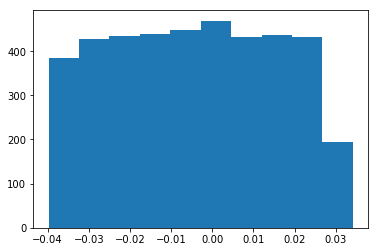

In [129]:
plt.hist(new_model.get_layer('predictions').get_weights()[0][:,0])

(array([  1.20000000e+01,   3.59000000e+02,   3.31800000e+03,
          9.27100000e+03,   8.39600000e+03,   3.06700000e+03,
          5.94000000e+02,   5.60000000e+01,   1.30000000e+01,
          2.00000000e+00]),
 array([-0.00976974, -0.00735361, -0.00493749, -0.00252137, -0.00010525,
         0.00231087,  0.004727  ,  0.00714312,  0.00955924,  0.01197536,
         0.01439148]),
 <a list of 10 Patch objects>)

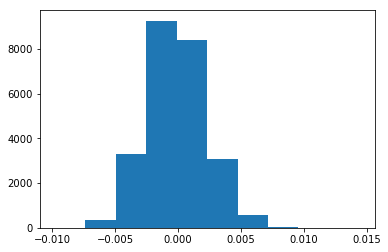

In [130]:
plt.hist(new_model.get_layer('fc1').get_weights()[0][:,0])

In [81]:
l = list(generator(joined,4))

0
1
2
3
4


In [131]:
for x,y in generator(joined,64):
    print(K.get_value(H_pred(new_model.predict(x),y)))
    

3.29688
3.40625
3.46875
2.90625


KeyboardInterrupt: 

(array([ 178.,  203.,  382.,  107.,   94.,   20.,   13.,    2.,    0.,    1.]),
 array([  0. ,   1.5,   3. ,   4.5,   6. ,   7.5,   9. ,  10.5,  12. ,
         13.5,  15. ]),
 <a list of 10 Patch objects>)

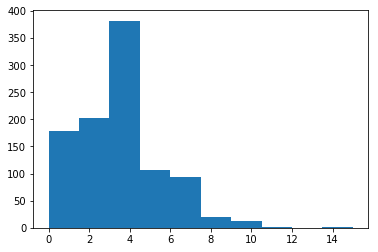

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(np.sum(attr[:1000],axis=1))